In [2]:
from math import pi
import pandas as pd
import numpy as np
import requests
import base64
import json
import spotipy
import spotipy.util as util
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import time

In [3]:
# initialize and authorize SpotipyOAuth 

usn = 'h_vy'
cid = '24da2914fefb43e198bf76d87e121f9c'
csc = '79bc72fb858041078caac075f9c369dd'
rur = 'http://localhost'
scp = 'user-read-private'

oam = spotipy.oauth2.SpotifyOAuth(username=usn, scope=scp, client_id=cid, client_secret=csc, redirect_uri=rur)
spo = spotipy.Spotify(oauth_manager=oam)

In [4]:
# feature categories
cat = ['danceability', 'energy', 'norm_loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']

In [5]:
# tracks of Fav playlist
fav_tracks = spo.playlist_tracks('2LlQtAk2KbOAGqgPwOUn9J')

In [6]:
"""
build and return a DataFrame of Track IDs and Names of Playlist Tracks
:trackJson: JSON Response, or Python dict, of Playlist Tracks
"""
def getTrackDf(trackJson):
    tracks = []
    for i in fav_tracks['items']:
        track = []
        track.append(i['track']['id'])
        track.append(i['track']['name'])
        track.append(i['track']['artists'][0]['name'])
        tracks.append(track)
    df = pd.DataFrame(data=tracks, columns=['id', 'name', 'artist'])
    return df

"""
build and return a DataFrame of Features of Multiple Tracks that 
include all features, track names and track IDs
:trackDf: list of track IDs 
:trackJson: JSON Response/Python dict of Tracks
"""
def getFeatureDf(featuresJson):
    featureDf = pd.DataFrame(featuresJson).set_index('id')

    # drop irrelevant columns
    featureDf.drop(['type', 'uri','track_href','analysis_url'], axis=1, inplace=True)

    # rescaling loudness
    minx = -60
    maxx = 0
    featureDf.insert(loc=3, column='norm_loudness', value=(featureDf['loudness']-minx)/(maxx-minx))

    return featureDf

In [7]:
t0 = time.time()
trackDf = getTrackDf(fav_tracks)
print('run time: {:.2f}'.format(time.time()-t0))
#features = sp.audio_features(trackId)

run time: 0.00


In [121]:
ch_id = trackDf.id[trackDf.artist.str.contains('Chillies')].tolist()

In [122]:
ft_ch = spo.audio_features(ch_id)

In [136]:
ftdf_ch = getFeatureDf(ft_ch)

[0.531, 0.317, 0.8240999999999999, 0.026, 0.816, 1.2e-06, 0.113, 0.302]

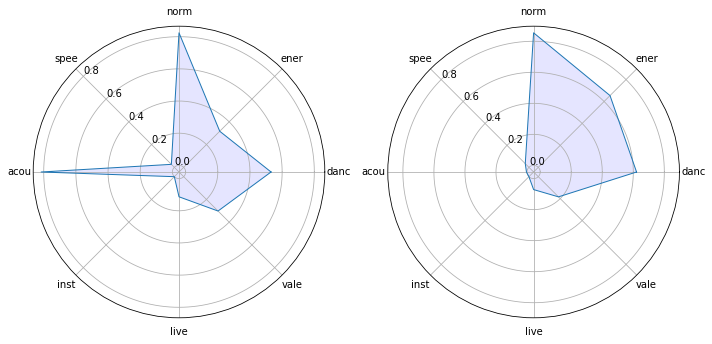

In [220]:
"""
draw a Radar Graph of a track's features
:track: list of features of a track
:cat: list of feature categories
:ax: Axes object to plot
"""
def radarGraph(track, cat, ax):
    
    # list of categories
    n = len(track)
    
    # duplicate first value to close the plot
    track += track[:1]

    angles = [i / float(n) * 2 * pi for i in range(n)]
    angles += angles[:1]
    
    # Plot data
    ax.plot(angles, track, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, track, 'b', alpha=0.1)
    
    # set gridlines and labels
    thetaticks = np.arange(0,360,45)
    ax.set_thetagrids(thetaticks, labels=cat, fontsize=10)
    ax.set_rlabel_position(135)
    
# initialize the radar graph for multiple track
nr, nc = 1, 2
fig, axes = plt.subplots(nrows=nr, ncols=nc, subplot_kw=dict(polar=True), figsize=(nr*10, nc*10))

# initialize indices for Axes list
if nr != 1: 
    l = [[x, y] for x in range(nr) for y in range(nc)]
else: l = [y for y in range(nc)]

# shorten category names
cat_sh = [c[:4] for c in cat]

# graph
for i, r in zip(l, enumerate(ftdf_ch[cat].itertuples())):
    radarGraph(list(r[1][1:]), cat_sh, axes[i])

plt.tight_layout()
plt.show()

In [207]:
ftdf_ch

,danceability,energy,key,norm_loudness,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
id,,,,,,,,,,,,,,
1lhdtLh7c6Y21O36qxCXxD,0.531,0.317,1,0.824100,-10.554,1,0.0260,0.81600,0.000001,0.1130,0.302,149.917,291651,3
1dZV513THyfDUONv351KVI,0.621,0.654,11,0.854567,-8.726,1,0.0333,0.00342,0.000037,0.0707,0.184,123.984,330968,4


In [218]:
pd.merge(ftdf_ch, trackDf, left_on='id', right_on='id')

,id,danceability,energy,key,norm_loudness,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,name,artist
0,1lhdtLh7c6Y21O36qxCXxD,0.531,0.317,1,0.824100,-10.554,1,0.0260,0.81600,0.000001,0.1130,0.302,149.917,291651,3,Và Thế Là Hết,Chillies
1,1dZV513THyfDUONv351KVI,0.621,0.654,11,0.854567,-8.726,1,0.0333,0.00342,0.000037,0.0707,0.184,123.984,330968,4,Nếu Ngày Mai Không Đến,Chillies


In [231]:
trackDf

,id,name,artist
0,0830WmzxBqOp9C93j8m9sN,Sign Of The Times - Spotify Studios NYC,LANY
1,1lhdtLh7c6Y21O36qxCXxD,Và Thế Là Hết,Chillies
2,1zVhMuH7agsRe6XkljIY4U,human,Christina Perri
3,69vToJ9BMbbLlFZo7k7A7B,You Are The Reason,Calum Scott
4,5A1w94uzc1kO1Zhe8WWxC3,Right Back,Khalid
...,...,...,...
77,2RMZcxr8c4SxZd9o6gw2CS,Tình Yêu Tôi Hát,Thùy Chi
78,4oIZ0rINU4XUsOp5zUWnju,5am,Cá Hồi Hoang
79,42rme4MN6ki6mXgl4yaZtV,Tầng Thượng 102,Cá Hồi Hoang
80,6N0uDUUQRQd7lIIFU2aaEQ,Hold Me,Eric Nam


In [12]:
ft_fav = spo.audio_features(trackDf.id.tolist())

In [14]:
featureDf = getFeatureDf(ft_fav)

In [16]:
ftdf = pd.merge(featureDf, trackDf, left_on='id', right_on='id')
ftdf.head()

,id,danceability,energy,key,norm_loudness,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,name,artist
0,0830WmzxBqOp9C93j8m9sN,0.619,0.394,5,0.837550,-9.747,1,0.0444,0.0472,0.020000,0.100,0.123,124.000,319750,4,Sign Of The Times - Spotify Studios NYC,LANY
1,1lhdtLh7c6Y21O36qxCXxD,0.531,0.317,1,0.824100,-10.554,1,0.0260,0.8160,0.000001,0.113,0.302,149.917,291651,3,Và Thế Là Hết,Chillies
2,1zVhMuH7agsRe6XkljIY4U,0.439,0.489,8,0.895233,-6.286,1,0.0368,0.1320,0.000643,0.114,0.253,143.808,250707,4,human,Christina Perri
3,69vToJ9BMbbLlFZo7k7A7B,0.331,0.235,10,0.871667,-7.700,1,0.0299,0.9180,0.000000,0.137,0.218,171.232,204326,3,You Are The Reason,Calum Scott
4,5A1w94uzc1kO1Zhe8WWxC3,0.788,0.427,5,0.834700,-9.918,0,0.3080,0.0649,0.000036,0.171,0.605,97.038,215227,4,Right Back,Khalid


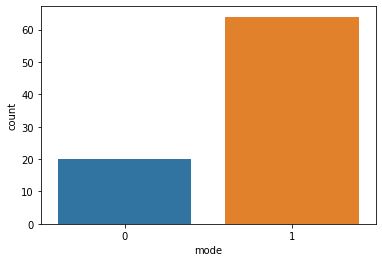

In [17]:
sns.countplot(x='mode', data=ftdf)

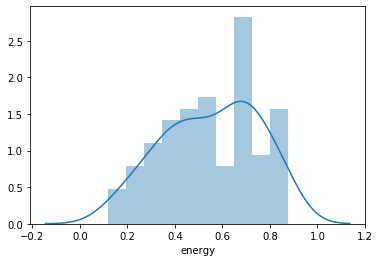

In [18]:
sns.distplot(ftdf.energy, bins=10)

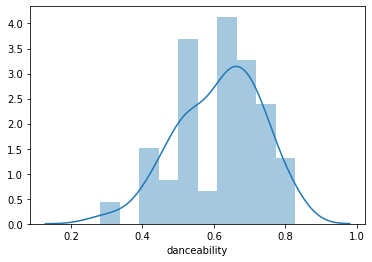

In [19]:
sns.distplot(ftdf.danceability, bins=10)

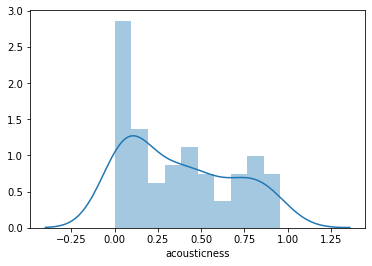

In [20]:
sns.distplot(ftdf.acousticness, bins=10)

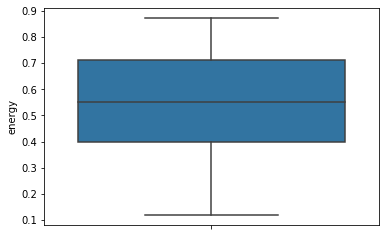

In [21]:
sns.boxplot(y=ftdf.energy)

In [29]:
list(reduce(lambda x: 'Chillies' in x, ftdf.artist.tolist()))

NameError: name 'reduce' is not defined